# Steered MD in BioSimSpace

Allosteric inhibition can be a useful alternative to conventional protein target-ing when the nature of the active site makes it difficult to design binders. This requires  assessment  of  whether  an  allosteric  binder  actually  has  an  effect  onprotein function, such as whether its presence shifts protein conformational ensemble to favour the inactive state. This can be modelled as a Markov chain by Markov State Models(MSMs).  Since the system is treated as memoryless, model building only requires local equilibrium. Therefore, it can make use of shorter MD simulations, allowing them to be run in parallel.

In order to have a more complete view of the protein ensemble, enhanced sampling methods are used, among them steered MD (sMD) (1). It introduces a bias potential that is added to the Hamiltonian, thus biasing the simulation towards a specified value of a chosen collective variable. Once the system has reached acertain conformation, those coordinates (2) can be used as starting points for equilibrium MD simulations (4) that can subsequently be used as data for constructing an MSM (4). An example summary of this is shown below:
<img src="figures/ensemble-md-protocol.png" width=300>

This tutorial focuses on running the prerequisite simulations using BSS.The example system used is protein tyrosine phosphatase 1B(PTP1B), which exists in two dominant conformations: WPD loop open and WPD loop closed:
<img src="figures/open-close.png" width=250>

## set up sMD

Running steered MD in BioSimSpace is very similar to regular simulations already covered. It only requires some more preparation for interfacing with PLUMED, the software that takes care of biasing the Hamiltonian.

We start by importing the required libraries:

In [2]:
import BioSimSpace as BSS
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from shutil import copyfile
[sys.path.remove(path) for path in sys.path if 'lib/python3.8/site-packages/pytraj-2.0.5-py3.8-linux-x86_64.egg' in path]
import pytraj as pt

In [3]:
#need these imports for now, but if we can prepare files in BSS they won't be necessary
sys.path.insert(1, '/'.join(sys.path[0].split('/')[:-1]))
from scripts.reference_files import renumber_pdb, rmsd_reference
from scripts.plumed_files import steered_md_plumed_input
from protocols_argparse_copyfiles.steered_md import calc_starting_rmsd

In [2]:
results_dir = '/home/adele/Documents/PTP1B-GROMACS'

In [3]:
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

Load a system with BioSimSpace. This particular system is of PTP1B with the WPD loop open (from PDB entry 2HNP) and has been minimised and equilibrated.

In [ ]:
system = BSS.IO.readMolecules([f'{results_dir}/system.top', f'{results_dir}/system.gro'])

Steered MD uses a specific CV, which in this case is RMSD of the WPD loop (residues 178-184). To calculate RMSD, we specify a reference structure first:

In [11]:
target_original_structure = '/home/adele/Documents/preparing-ptp1b/for-use/ptp1b-closed.pdb'

For PLUMED to correctly calculate the RMSD, the atom indices of the target reference structure have to match the system, which might not always be the case. To enure this, we therefore renumber the target PDB to have matching atom indices:

In [15]:
renumber_pdb(target_original_structure, system, f'{results_dir}/renumbered_target.pdb')

Created /home/adele/Documents/PTP1B-GROMACS/renumbered_target.pdb


PLUMED uses the occupancy and $\beta$ columns of the reference PDB file to indicate which atoms are to be used for system alignment and which are to be used for RMSD calculation, respectively. Therefore these are changed to specify only the WPD loop for RMSD (note the offset by 1 residue to accomodate the ACE cap on the N terminus):

In [16]:
rmsd_reference(f'{results_dir}/renumbered_target.pdb', '179-185', f'{results_dir}/target.pdb')

Created /home/adele/Documents/PTP1B-GROMACS/target.pdb


Having the reference files ready, we create the protocol and process in BioSimSpace, as for any other simulation. The steering duration here will be 150 ns, with additional 2 ns added at the end when all biases will be removed.

In [7]:
steering_protocol = BSS.Protocol.Production(runtime=152*BSS.Units.Time.nanosecond, report_interval=2500, restart_interval=2500)
steering_process = BSS.Process.Gromacs(system, steering_protocol)

The process is adjusted to specify a single GPU, a single CPU and the PLUMED input file

**(might want to change this part depending on native BSS implementation)**

In [20]:
new_args = steering_process.getArgs()
new_args['-gpu_id'] = 0
new_args['-nt'] = 1
new_args['-plumed'] = 'plumed.dat'
steering_process.setArgs(new_args)

Now the PLUMED input file (called plumed.dat) has to be created and placed in the working directory of the process. PLUMED will have to calculate the CV (RMSD in our case) and use it in a [moving restraint](https://www.plumed.org/doc-v2.5/user-doc/html/_m_o_v_i_n_g_r_e_s_t_r_a_i_n_t.html) that is calculated as follows:

$V(\vec{s},t) = \frac{1}{2} \kappa(t) ( \vec{s} - \vec{s}_0(t) )^2$

where $\vec{s}_0$ and $\kappa$ are time dependent and specified in the PLUMED input. $\vec{s}_0$ is the target CV value and $\kappa$ is the force constant in kJ mol$^{-1}$. The values of both of them are set at specific steps, and linearly interpolated in between. We also have to calculate a starting RMSD value for PLUMED to expect at the start of the simulation.

In [14]:
starting_rmsd = calc_starting_rmsd(system, target_original_structure)

In [16]:
steering_steps = int(150*BSS.Units.Time.nanosecond/steering_protocol.getTimeStep())
total_steps = steering_steps + int(2*BSS.Units.Time.nanosecond/steering_protocol.getTimeStep())

In [21]:
steered_md_plumed_input(f'/home/adele/Documents/PTP1B-GROMACS/target.pdb', starting_rmsd, (steering_steps, total_steps), 3500, [f'{steering_process.workDir()}/plumed.dat', f'{results_dir}/plumed.dat'])

Created PLUMED input file.


['rmsd: RMSD REFERENCE=/home/adele/Documents/PTP1B-GROMACS/target.pdb TYPE=OPTIMAL\n',
 'MOVINGRESTRAINT ...\n  ARG=rmsd\n  LABEL=forces\n  STEP0=0            AT0=0.550000011920929  KAPPA0=0\n  STEP1=2000         AT1=0.550000011920929  KAPPA1=3500\n  STEP2=75000000   AT2=0.0   KAPPA2=3500\n  STEP3=76000000   AT3=0.0   KAPPA3=0\n... MOVINGRESTRAINT\n',
 'PRINT ARG=rmsd,forces.bias STRIDE=2500 FILE=steering.dat\n']

## Run sMD:

The steered MD simulation itself now can be run either in a notebook, or moved to a HPC cluster. The interface with PLUMED does slow down simulations, so that is something to be considered.

We need to set some environment variables to use PLUMED. This can also be done in command line or a submission script and will depend on where PLUMED is installed on the specific system.

In [5]:
os.environ['PLUMED_KERNEL'] = '/usr/local/lib/libplumedKernel.so'
os.environ['LD_LIBRARY_PATH'] = f'/usr/local/lib:{os.environ["LD_LIBRARY_PATH"]}'

In [22]:
steering_process.start()

BioSimSpace.Process.Gromacs(<BioSimSpace.System: nMolecules=11900>, BioSimSpace.Protocol.Production(timestep=2.0000 fs, runtime=152.0000 ns, temperature=300.0000 K, pressure=1.0000 atm, report_interval=2500, restart_interval=2500, first_step=0, restart=False), exe='/usr/local/gromacs/bin/gmx', name='gromacs', work_dir='/tmp/tmphw_y5473', seed=None)

As the simulation runs, PLUMED outputs a file with the CV values. It can be used to track simulation progress:

(0.0, 150.0)

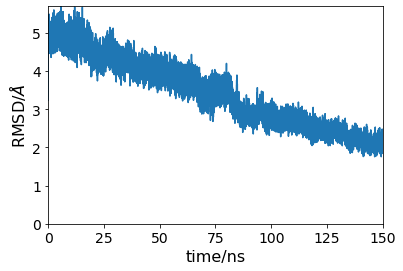

In [23]:
steering_output_file = f'{steering_process.workDir()}/steering.dat'
steering_output = pd.read_csv(steering_output_file, sep=' ', comment='#', names=['time/ps', 'RMSD', 'forces'], skipinitialspace=1)
fig,ax = plt.subplots(1, figsize=(12,5))
ax.plot(steering_output['time/ps']/1000, steering_output['RMSD']*10)
ax.set_ylabel('RMSD/$\AA$')
ax.set_ylim(0, steering_output['RMSD'].max()*10)
ax.set_xlabel('time/ns')
ax.set_xlim(0, 150)

Once the simulation is complete, the output can be copied over (if the simulation was run in a temporary directory).

In [24]:
files_to_copy = ['.gro', '.top', '.out', '.trr', '.dat']
for file in os.listdir(steering_process.workDir()):
    for extension in files_to_copy:
        if extension in file:
            copyfile(f'{steering_process.workDir()}/{file}', f'{results_dir}/{file}')